# Predicting House Sale Prices with Linear Regression

## Introduction

Today I'll be creating a linear regression model to predict house sale prices, training it on a data set describing the sale of individual residential properties in Ames, Iowa from 2006 to 2010. 

I'm building a linear regression work flow, creating a pipeline of functions as follows:

> #### Data In -> `transform_features()` -> `select_features()` -> `train_and_test()` -> Evaluation Out

The goal is to enable rapid iteration on different models, and once I have my function pipeline set up it should be easy to do so; experimenting by passing in different arguments and evaluating the results to determine their impact on the accuracy of my model's house sale price predictions.

`transform_features()`  
This is where I will do my feature engineering - imputing values and stripping out nulls, unwanted data types, columns with data leakage and incorrect values.

`select_features()`  
I'll use this function to select columns to include as features. I'll look at correlation, in-column variance and at transforming nominal and ordinal data to categorical values.

`train_and_test()`  
Here I'll train and test the model, building it to handle holdout and k-fold cross validation.


### Data Set
The data set contains 2930 observations and 80 explanatory variables involved in assessing home values.  

- Data column descriptions [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).
- Info about why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627)
- The dataset itself can be downloaded from [here](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt)

Let's import the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split

data = pd.read_csv('AmesHousing.tsv', sep='\t')
pd.set_option('max_columns', 100)
data.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Outliers
As per the [documentation special notes](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), I remove the below 5 outliers.

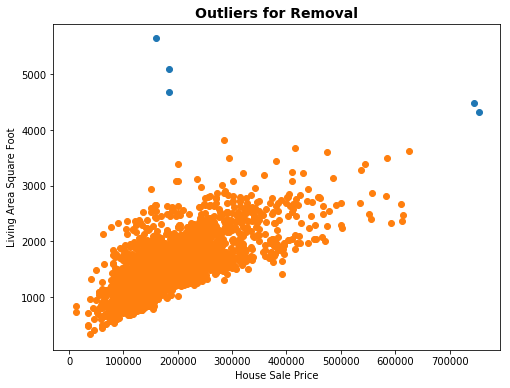

Before: (5, 82)
After: (0, 82)


In [2]:
# Plot the outliers
plt.figure(figsize=(8,6))
x = data.loc[data['Gr Liv Area'] > 4000, 'SalePrice']
y = data.loc[data['Gr Liv Area'] > 4000, 'Gr Liv Area']
plt.scatter(x, y, cmap='viridis')

x = data.loc[data['Gr Liv Area'] <= 4000, 'SalePrice']
y = data.loc[data['Gr Liv Area'] <= 4000, 'Gr Liv Area']
plt.scatter(x, y, cmap='viridis')

plt.xlabel('House Sale Price')
plt.ylabel('Living Area Square Foot')
plt.title('Outliers for Removal', fontsize=14, fontweight='bold')
plt.savefig('ames_outliers.png')
plt.show()

print('Before:', data[data['Gr Liv Area'] > 4000].shape)

# Drop the outliers
data.drop(data[data['Gr Liv Area'] > 4000].index, inplace=True)

# Check
print('After:', data[data['Gr Liv Area'] > 4000].shape)


Let's begin by setting up my basic pipeline of helper functions that will let me quickly iterate on different models.

- `transform_features()`  
    For now, this just returns the dataframe
- `select_features()`  
    For now, this just returns the `Gr Liv` and `SalePrice` columns from the `data` dataframe
- `train_and_test()`  
    For now, this 
    - splits the `data` dataframe into `train` and `test`
    - trains a model using all numerical columns except our target `SalePrice` from the dataframe returned from `select_features()`
    - tests the model on the test set and evaluates, returning the `RMSE` value

### A note on `RMSE`
The `RMSE` is the absolute fit of the model to the data - the measure of how close the model's predicted values are to the observed data. It is the standard deviation of the prediction errors, so tells us the average variability of our predictions above and below the line of best fit or regression line. As such, the lower the `RMSE` the more accurate we can say our model is at predicting the response. 

The `RMSE` is in the same units as our target variable, which makes for intuitive understanding of the model's evaluation.

e.g. if my `RMSE` is 50,000, I know that I am on average predicting \$50,000 above or below the observed house sale price.


In [3]:
def transform_features(data):
    return data

def select_features(data):
    return data[['Gr Liv Area', 'SalePrice']]

def train_and_test(data):
    train, test = train_test_split(data, test_size=0.50, random_state = 1)

    target = 'SalePrice'
    features_df = select_features(data)
    feature_cols = features_df.select_dtypes(include=['integer', 'float']).drop('SalePrice', axis=1).columns
    
    lr = LinearRegression()
    lr.fit(train[feature_cols], train[target])
    
    predictions = lr.predict(test[feature_cols])
    
    mse = mean_squared_error(predictions, test[target])
    rmse = np.sqrt(mse)
    return rmse

# Return RMSE
train_and_test(data)

54020.48763702078

## Feature Engineering

Let's experiment with transforming our features, then once I'm satisfied, build these transformations into my `transform_features()` function.


### Nulls / Missing Values
First I want to get a sense of the distribution of missing values in the data. I'm going to use the following to help me out.
- Heatmap of null values
- Null count

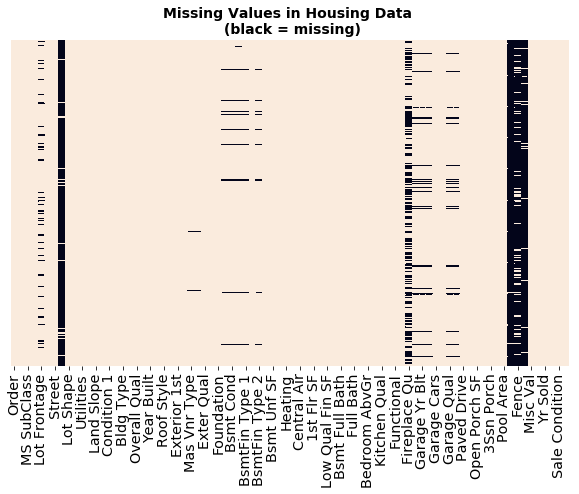

In [4]:
# Build heatmap to check for nulls

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_null_matrix(df, figsize=(18,14)):
    # Initiate the figure
    plt.figure(figsize=figsize)
    
    # Create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    
    # Create a heatmap of the boolean dataframe: null=dark, non-null = light
    sns.heatmap(~df_null, cbar=False, yticklabels=False) 
    plt.xticks(rotation=90, size='x-large')
    plt.title('Missing Values in Housing Data \n (black = missing)', fontsize=14, fontweight='bold')
    plt.savefig('ames_heatmap.png')
    plt.show()

    
plot_null_matrix(data, figsize=(10,6))

Some columns appear almost totally null. Let's get some quantitative data around this.

In [5]:
# Get percentage of nulls in a col
(data.isnull().sum().sort_values(ascending=False) / data.shape[0] *100)[:30]


Pool QC           99.623932
Misc Feature      96.410256
Alley             93.230769
Fence             80.478632
Fireplace Qu      48.615385
Lot Frontage      16.752137
Garage Qual        5.435897
Garage Yr Blt      5.435897
Garage Cond        5.435897
Garage Finish      5.435897
Garage Type        5.367521
Bsmt Exposure      2.837607
BsmtFin Type 2     2.769231
BsmtFin Type 1     2.735043
Bsmt Cond          2.735043
Bsmt Qual          2.735043
Mas Vnr Type       0.786325
Mas Vnr Area       0.786325
Bsmt Full Bath     0.068376
Bsmt Half Bath     0.068376
Garage Area        0.034188
Garage Cars        0.034188
Total Bsmt SF      0.034188
Bsmt Unf SF        0.034188
BsmtFin SF 2       0.034188
BsmtFin SF 1       0.034188
Electrical         0.034188
Exterior 2nd       0.000000
Exterior 1st       0.000000
Roof Matl          0.000000
dtype: float64

### Strategies for missing values

- I set a null threshold of 5% and will drop all columns with > 5% missing values. 
    - I'll be sure to include the null threshold as a parameter in my function so that I can experiment with different values for this threshold to see if it impacts model performance
- For nulls in remaining numeric columns, I will replace missing values with the `average` value
- For the remaining text columns with missing values, I will drop the rows where there are missing values


1. Drop all columns with > 5% missing values

In [6]:
# Shape before drop
print('Before:', data.shape)

# Get cols to drop, those with missing values > 5%
nulls_over_5perc = data.isnull().sum()[data.isnull().sum() > data.shape[0]/20]

# Drop these cols
data.drop(nulls_over_5perc.index, axis=1, inplace=True)

# Shape after drop
print('After:', data.shape)

Before: (2925, 82)
After: (2925, 71)


2. For the remaining nulls in the remaining numeric columns , replace with the 'average' value

What statistic should I use as my average? Let's take a look at the data.

Index(['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars',
       'Garage Area'],
      dtype='object')


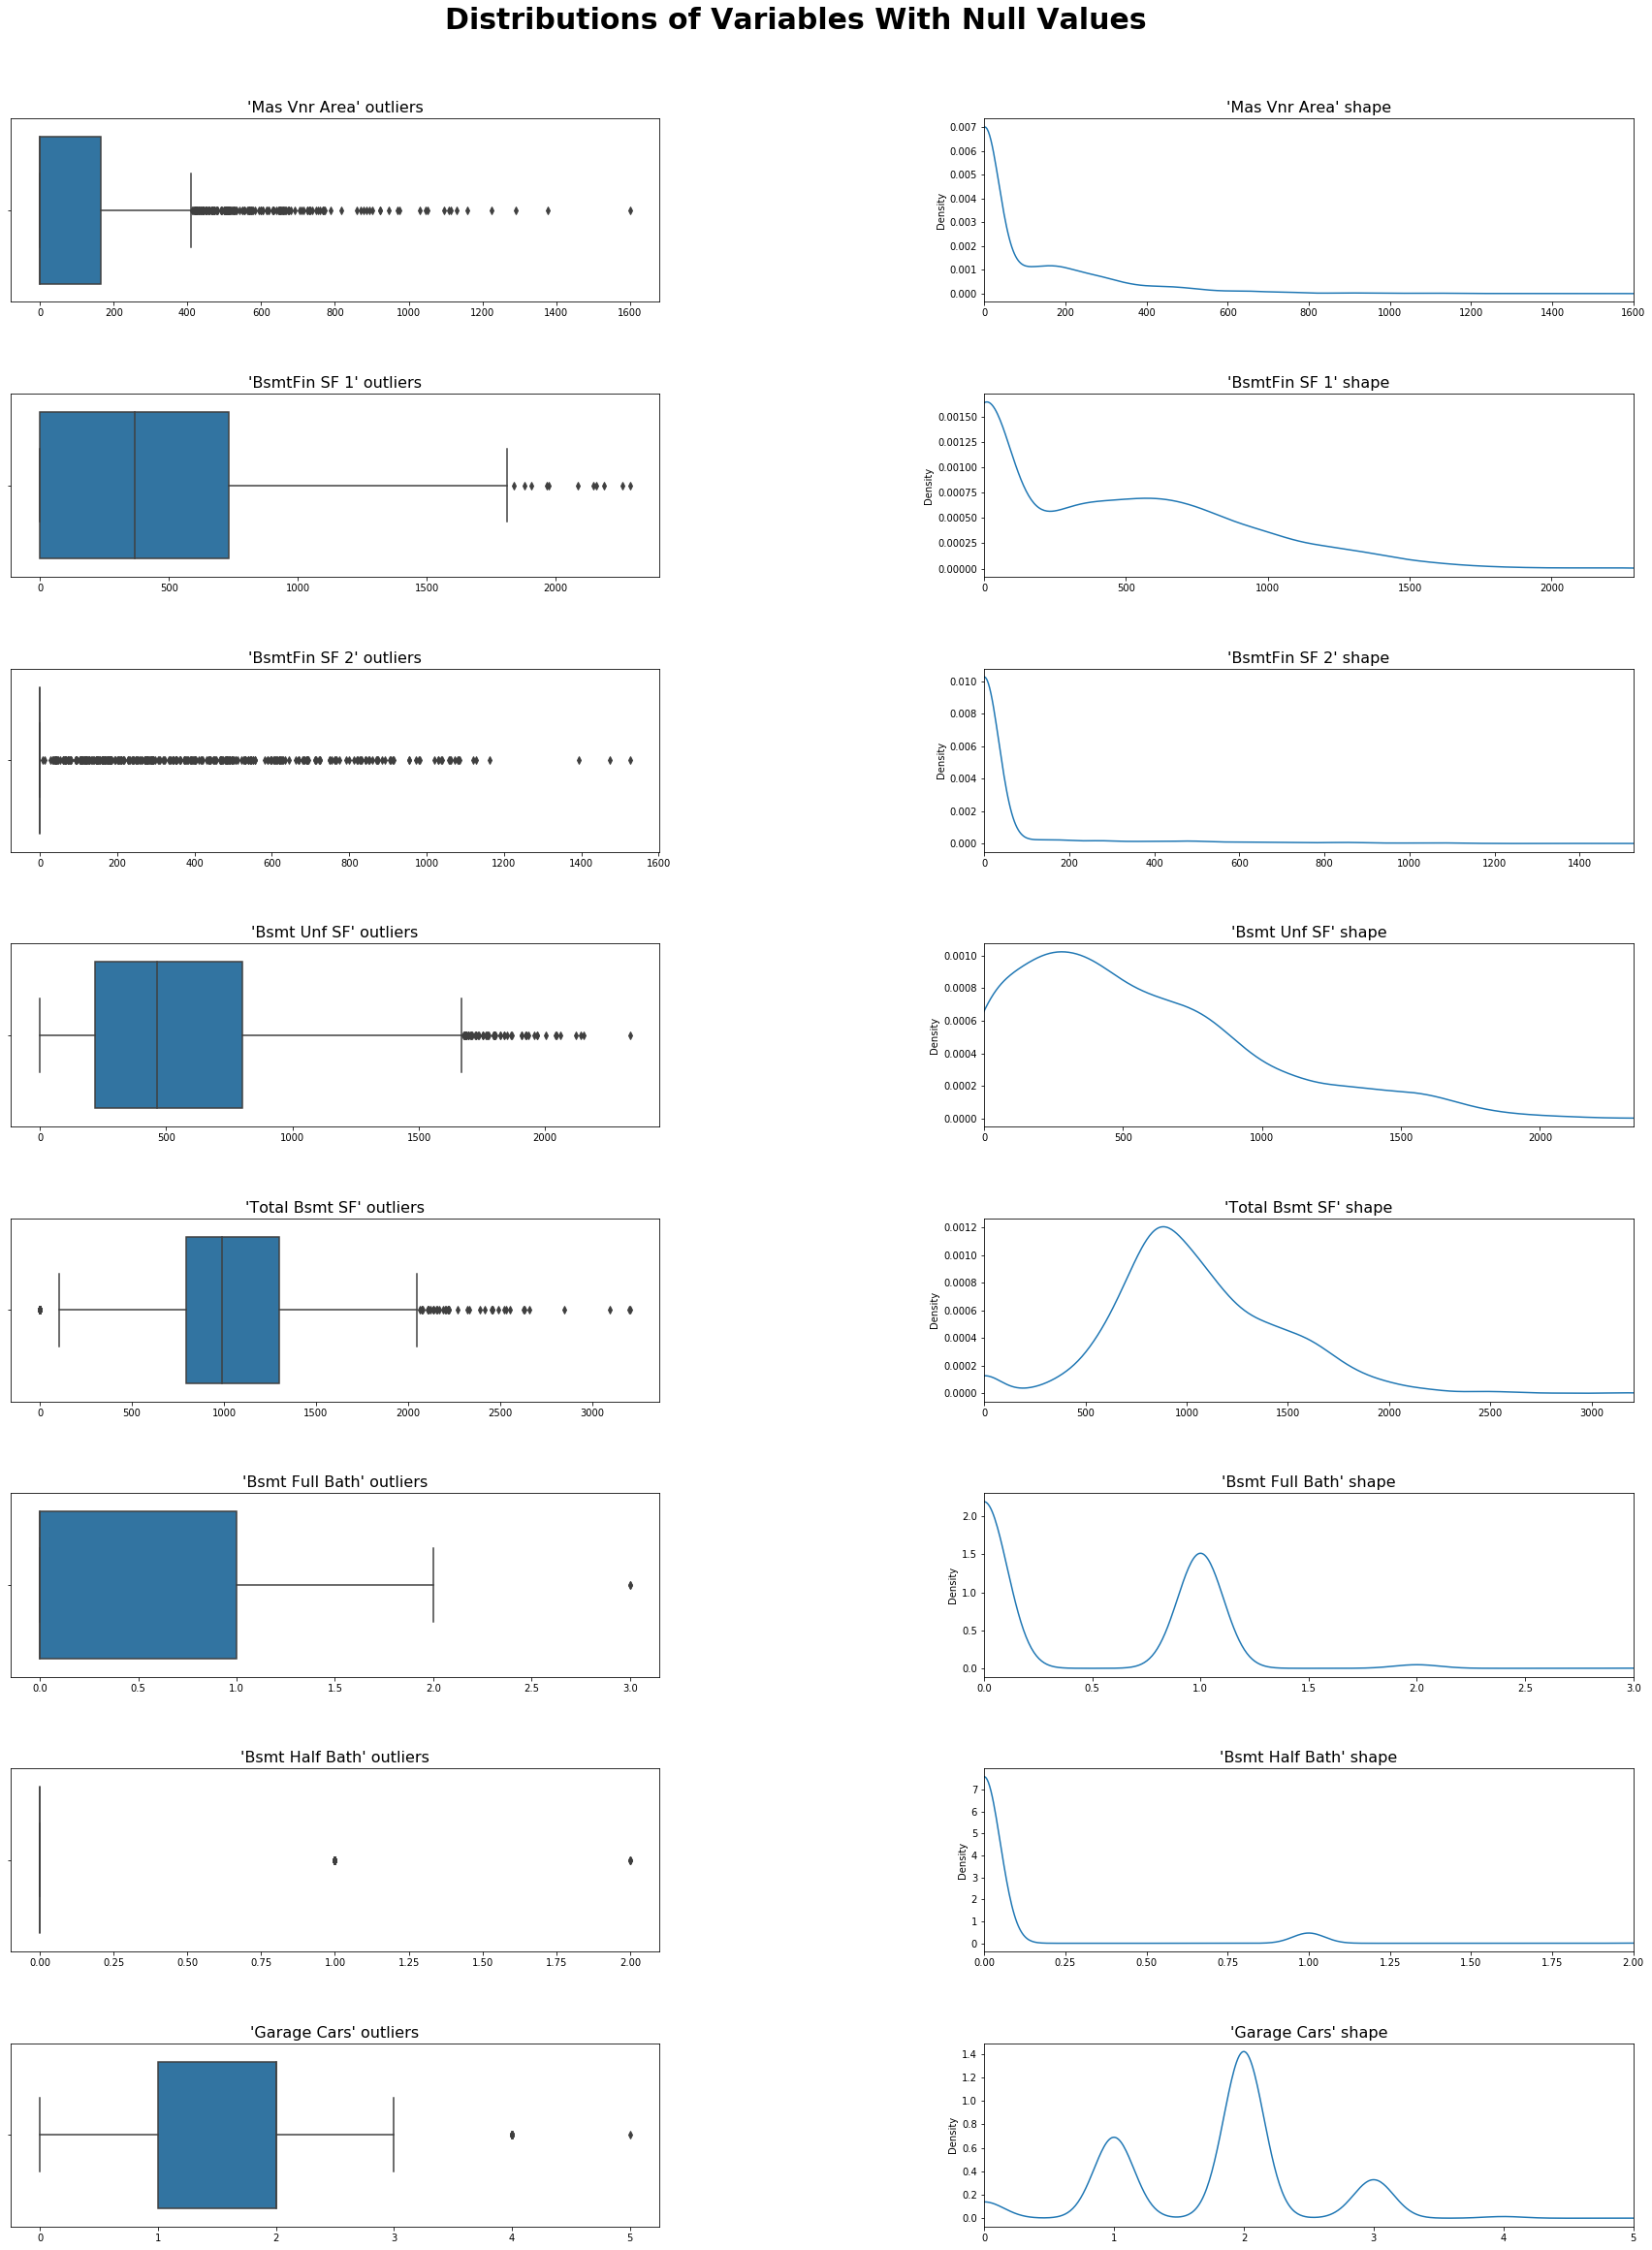

In [7]:
# Get remaining null cols
remaining_nulls = data.isnull().sum()[data.isnull().sum() > 0]

# Get Numeric columns with nulls
numeric_nulls = data[remaining_nulls.index].select_dtypes(include=np.number)
cols = numeric_nulls.columns
print(cols)

# Create figure showing distributions of columns with nulls
fig = plt.figure(figsize=(30, 40))
fig.subplots_adjust(wspace=.5, hspace=0.5)
fig.suptitle('Distributions of Variables With Null Values', y=.92, fontsize=30, fontweight='bold')

# Show boxplots in column 1 of figure
for i in range(0,16,2):
    ax = fig.add_subplot(8,2,i+1)
    r = int(i/2)
    sns.boxplot(numeric_nulls[cols[r]])
    ax.set_xlabel('')
    ax.set_title("'" + str(cols[r]) + "'" + ' outliers', fontsize=16)

# Show KDEs in column 2 of figure
for i in range(0,16,2): 
    ax = fig.add_subplot(8,2,i+2)
    r = int(i/2)
    numeric_nulls[cols[r]].plot.kde()
    ax.set_xlim(numeric_nulls[cols[r]].min(), numeric_nulls[cols[r]].max())
    ax.set_title("'" + str(cols[r]) + "'" + ' shape', fontsize=16)

plt.savefig('ames_null_distros.png')    
plt.show()

The remaining numeric columns with nulls are all on the interval/ratio scale, containing continuous and discrete values, as per the [documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

I can see the distributions are heavily skewed, so I decide to impute using the `median` value as it more resistant to the effects of outliers.

In [8]:
# Replace nulls with median value
data[numeric_nulls.columns] = data[numeric_nulls.columns].fillna(data[numeric_nulls.columns].median())

# Check no nulls remain for above numeric cols
data.isnull().sum().sort_values(ascending=False)[:10]

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Cond         80
Bsmt Qual         80
Mas Vnr Type      23
Electrical         1
SalePrice          0
Exterior 1st       0
Year Remod/Add     0
dtype: int64

3. For the remaining text columns with missing values, I drop the rows where there are missing values 

In [9]:
# Ensure remaining cols with nulls are text cols
print(data[data.isnull().sum()[data.isnull().sum() > 0].index].dtypes)
print('\n')
print('Before:', data.shape)

# Drop rows with any nulls
data.dropna(inplace=True)

# Check 
print('After:', data.shape)
data.isnull().sum().sort_values(ascending=False)[:10]

Mas Vnr Type      object
Bsmt Qual         object
Bsmt Cond         object
Bsmt Exposure     object
BsmtFin Type 1    object
BsmtFin Type 2    object
Electrical        object
dtype: object


Before: (2925, 71)
After: (2817, 71)


SalePrice         0
Mas Vnr Area      0
Year Remod/Add    0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
Exter Qual        0
Overall Cond      0
dtype: int64

### Create Features

Looking at the existing columns, I see I can create two useful features that will give me:
- Age of house at sale
- Years since remodelling  


1. `age_at_sale`

In [10]:
age_at_sale = data['Yr Sold'] - data['Year Built']

# Check for incorrect values
age_at_sale[age_at_sale < 0]

Series([], dtype: int64)

2. `years_since_remodel`  

There is one row which returns a negative value here - the remodelled date is greater than the sold date. This is either data leakage or, more likely, an error in the data. Either way I decide to drop it.

In [11]:
years_since_remodel = data['Yr Sold'] - data['Year Remod/Add']

# Check for incorrect values
years_since_remodel[years_since_remodel < 0]

1702   -1
dtype: int64

I drop the above incorrect row, add these two newly created columns to our data set, and drop the original two columns.

In [12]:
# Create new cols and drop the row with the incorrect, negative value
data['age_at_sale'] = age_at_sale
data['years_since_remodel'] = years_since_remodel

data = data.drop(years_since_remodel[years_since_remodel < 0].index)

# Check
data[data['years_since_remodel'] < 0]

# No longer need original year columns
data = data.drop(['Year Built', 'Year Remod/Add'], axis = 1)

### Drop columns

I'll now get rid of columns which:

- are irrelevant or provide no value to the model
- will leak data about the final sale, thereby overfitting the model

#### A note on data leakage
Currently all rows contain data relating to the sale of the house. However, when we're trying to predict a house sale price, we wouldn't have access to data such as the `Sale Type` or `Yr Sold`, because the sale hasn't happened yet. We need to make sure we don't train our model on data that wouldn't be available to us in a real world scenario, otherwise we're overfitting, building a model that will work really well in training, but won't do as well in production.


In [13]:
# Drop order and PID - not useful
data = data.drop(['Order', 'PID'], axis=1)

# Drop data leakage cols i.e. cols with data about the sale
data = data.drop(['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'], axis=1)
data.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,age_at_sale,years_since_remodel
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,172000,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,244000,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,189900,13,12


### Update function `transform_features()`

I'll now incorporate the above changes into my `transform_features()` function and run my pipeline, getting an RMSE of 52.5K. Not to worry though, I still have my feature selection and training to go.

In [14]:
def transform_features(data, null_thresh=0.05):
    # Drop the outliers as advised in the documetation
    data.drop(data[data['Gr Liv Area'] > 4000].index, inplace=True)
    
    # Drop cols with missing values > our threshold (default 5%)
    nulls_over_thresh = data.isnull().sum()[data.isnull().sum() > len(data)*null_thresh]
    data.drop(nulls_over_thresh.index, axis=1, inplace=True)    
    
    # Impute values for remaining numeric null cols
    remaining_nulls = data.isnull().sum()[data.isnull().sum() > 0]
    numeric_nulls = data[remaining_nulls.index].select_dtypes(include=['float', 'integer'])
    data[numeric_nulls.columns] = data[numeric_nulls.columns].fillna(data[numeric_nulls.columns].median())
    
    # Drop remainging rows with any nulls (all text)
    data.dropna(axis = 1, inplace=True)
    
    # Add features
    data['age_at_sale'] = data['Yr Sold'] - data['Year Built']
    data['years_since_remodel'] = data['Yr Sold'] - data['Year Remod/Add']
    
    # Drop incorrect values
    data = data.drop(1702, axis=0)
    
    # Drop unhelpful / data leakage cols
    data = data.drop(['Order', 'PID', 'Mo Sold', 'Sale Type', 'Sale Condition', 'Year Built', 'Year Remod/Add'], axis=1)
    return data

def select_features(data):
    return data[['Gr Liv Area', 'SalePrice']]

def train_and_test(data):
#     train = data[:1460].copy()
#     test = data[1460:].copy()
    train, test = train_test_split(data, test_size=0.50, random_state = 1)
    
    # Get numeric train and test
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    # Features and target
    target = 'SalePrice'
    features = numeric_train.drop('SalePrice', axis=1).columns
    
    # Model
    lr = LinearRegression()
    lr.fit(numeric_train[features], numeric_train[target])
    predictions = lr.predict(numeric_test[features])
    
    mse = mean_squared_error(predictions, numeric_test[target])
    rmse = np.sqrt(mse)
    return rmse

data = pd.read_csv("AmesHousing.tsv", delimiter="\t")

transformed = transform_features(data)
selected = select_features(transformed)
rmse = train_and_test(selected)

rmse


52522.800606230994

## Feature Selection

This is where I select which columns I'll keep to train my model. 

First I generate a correlation heatmap matrix of the numerical features in the training data to see which ones have a strong correlation with my target `'SalePrice'`.

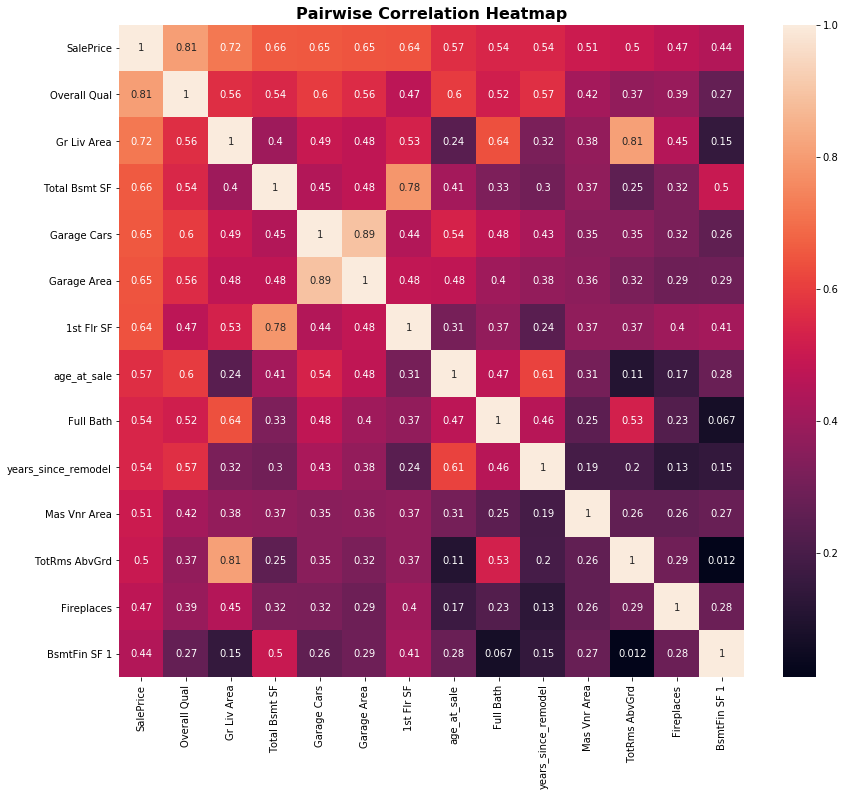

In [15]:
numerical_data = transformed.select_dtypes(include=['float', 'integer'])

# Correlation between 'SalePrice' and all other numeric cols
target_data_corr = numerical_data.corr().abs()['SalePrice'].sort_values(ascending=False)

# Keep only cols which have a strong corr with the target col
# arbitrary cutoff of 0.4
strong_corr_cols = target_data_corr[target_data_corr > 0.4].index

# Do pairwise correlation of all features which are stronly correlated to 'SalePrice'
strong_corrs = transformed[strong_corr_cols].corr().abs()

# Generate heatmap
plt.figure(figsize=(14,12))
sns.heatmap(strong_corrs, annot=True)
plt.title('Pairwise Correlation Heatmap', fontsize=16, fontweight='bold')
plt.savefig('ames_corr_heatmap.png')
plt.show()

I need to choose a correlation coefficient threshold, and drop all numeric columns which fall below it. Here I'm going to use 0.4, but I'll make sure to include it as a parameter in my function so I can experiment with different values.

In [16]:
# Get columns with weak correlation
weak_corr_cols = target_data_corr[target_data_corr < 0.4].index
weak_corr_cols

print('Before:', transformed.shape)

transformed.drop(weak_corr_cols, axis=1, inplace=True)
print('After:', transformed.shape)

Before: (2924, 59)
After: (2924, 39)


In [17]:
transformed.columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'BsmtFin SF 1',
       'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', '1st Flr SF',
       'Gr Liv Area', 'Full Bath', 'Kitchen Qual', 'TotRms AbvGrd',
       'Functional', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Paved Drive',
       'SalePrice', 'age_at_sale', 'years_since_remodel'],
      dtype='object')

### Collinearity

I can see strong correlation between the following pairs of features so I investigate further for collinearity and repetition of information.
- `Gr Liv Area` and `TotRms AbvGrd`
- `Garage Cars` and `Garage Area`
- `1st Flr SF` and `Total Basement SF`

I decide there is repetition of data between the first 2 pairs. I will drop `TotRms AbvGrd` and `Garage Cars`, as both `Gr Liv Area` and `Garage Area` are continuous variables, containing more nuanced data than their counterparts.

While there is strong correlation between `1st Flr SF` and `Total Basement SF`, I decide not to drop either, as some houses might not have a basement, and some might not have a 1st floor.

In [18]:
transformed = transformed.drop(['TotRms AbvGrd', 'Garage Cars'], axis=1)
transformed.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,Functional,Fireplaces,Garage Area,Paved Drive,SalePrice,age_at_sale,years_since_remodel
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,1080.0,GasA,Fa,Y,1656,1656,1,TA,Typ,2,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,882.0,GasA,TA,Y,896,896,1,TA,Typ,0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,1329.0,GasA,TA,Y,1329,1329,1,Gd,Typ,0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,2110.0,GasA,Ex,Y,2110,2110,2,Ex,Typ,2,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,928.0,GasA,Gd,Y,928,1629,2,TA,Typ,1,482.0,Y,189900,13,12


### Categorical Columns

I now turn the investigation towards which features should be converted to categorical data type. 

All columns that can be categorised as nominal or ordinal variables are candidates here.

Things to keep in mind:
- Columns with hundreds of unique variables being converted to dummy code will result in hundreds of new columns being added to the data frame, adding complexity
- Those with few unique variables, but low variance (e.g. 95% of values are 1 specific category) will not add value to my model


Let's look at [nominal and ordinal variable columns](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) that were originally included in the data set.

In [19]:
# Nominal variable columns, as per the documentation
nom_ord_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition", 'Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 
                    'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 
                   'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive',
                   'Pool QC', 'Fence']



Now I'll see which of these original features still remain following the `transform_features()` step which was completed above and how many unique variables each one has.

In [20]:
# Select nominal and ordinal features from our transformed data set
transform_nom_ord_cols = [col for col in transformed.columns if col in nom_ord_features]

# Get unique value count for each feature
nom_cols_unique_count = transformed[transform_nom_ord_cols].apply(lambda col: len(col.value_counts())).sort_values()
nom_cols_unique_count


Street           2
Central Air      2
Paved Drive      3
Utilities        3
Land Slope       3
Lot Shape        4
Land Contour     4
Exter Qual       4
Lot Config       5
Kitchen Qual     5
Heating QC       5
Bldg Type        5
Exter Cond       5
Heating          6
Foundation       6
Roof Style       6
MS Zoning        7
Roof Matl        7
Functional       8
House Style      8
Condition 2      8
Condition 1      9
Overall Qual    10
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

I decide to try an arbitrary unique category count cutoff of 10, dropping columns with more than 10 unique categories or values. We can iterate on this later.

*Note:* `Overall Qual`, when treated as a numeric column in the correlation heatmap above, was the feature with the highest correlation to my target. It has 10 unique values and for now I am interested in including it.

In [21]:
# Drop variables with more than 10 unique categories/values
transformed = transformed.drop(nom_cols_unique_count[nom_cols_unique_count > 10].index, axis=1)

# check
transformed.columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Roof Style', 'Roof Matl',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Kitchen Qual', 'Functional',
       'Fireplaces', 'Garage Area', 'Paved Drive', 'SalePrice', 'age_at_sale',
       'years_since_remodel'],
      dtype='object')

Now I want to investigate the in-feature variance, remembering that features with low variance will not add much value to the model.

I find 6 features that have one category making > 95% of the total values.

In [22]:
# Find features with one category making up > 95% of the total values
low_variance = [] 

for col in transformed:
    val_counts = (transformed[col].value_counts(normalize=True) *100)
    if val_counts.values[0] > 94:
        low_variance.append(col)

# Display
print(low_variance)

# Confirm
for col in low_variance:
    print(col)
    print(transformed[col].value_counts(normalize=True)*100)
    print('-----------------')


['Street', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'Heating']
Street
Pave    99.589603
Grvl     0.410397
Name: Street, dtype: float64
-----------------
Utilities
AllPub    99.897401
NoSewr     0.068399
NoSeWa     0.034200
Name: Utilities, dtype: float64
-----------------
Land Slope
Gtl    95.177839
Mod     4.274966
Sev     0.547196
Name: Land Slope, dtype: float64
-----------------
Condition 2
Norm      99.008208
Feedr      0.444596
Artery     0.170999
PosA       0.136799
PosN       0.102599
RRNn       0.068399
RRAe       0.034200
RRAn       0.034200
Name: Condition 2, dtype: float64
-----------------
Roof Matl
CompShg    98.597811
Tar&Grv     0.786594
WdShake     0.307798
WdShngl     0.205198
Roll        0.034200
Membran     0.034200
Metal       0.034200
Name: Roof Matl, dtype: float64
-----------------
Heating
GasA     98.461012
GasW      0.923393
Grav      0.307798
Wall      0.205198
OthW      0.068399
Floor     0.034200
Name: Heating, dtype: float64
-----------------

I drop these low-variance features.

In [23]:
# Drop low variance features
transformed = transformed.drop(low_variance, axis=1)

# Check
transformed.columns

Index(['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Condition 1',
       'Bldg Type', 'House Style', 'Overall Qual', 'Roof Style',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC', 'Central Air',
       '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Kitchen Qual', 'Functional',
       'Fireplaces', 'Garage Area', 'Paved Drive', 'SalePrice', 'age_at_sale',
       'years_since_remodel'],
      dtype='object')

Now it's time to transform our selected nominal and ordinal variables into categorical variables. Note, all of them currently have data type `object` except for `Overall Qual` which has `int` data type.

In [24]:
# Display data types for the remaining selected nominal and ordinal variables
cat_feats = [col for col in transformed.columns if col in nom_ord_features]
transformed[cat_feats].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2924 entries, 0 to 2929
Data columns (total 17 columns):
MS Zoning       2924 non-null object
Lot Shape       2924 non-null object
Land Contour    2924 non-null object
Lot Config      2924 non-null object
Condition 1     2924 non-null object
Bldg Type       2924 non-null object
House Style     2924 non-null object
Overall Qual    2924 non-null int64
Roof Style      2924 non-null object
Exter Qual      2924 non-null object
Exter Cond      2924 non-null object
Foundation      2924 non-null object
Heating QC      2924 non-null object
Central Air     2924 non-null object
Kitchen Qual    2924 non-null object
Functional      2924 non-null object
Paved Drive     2924 non-null object
dtypes: int64(1), object(16)
memory usage: 411.2+ KB


I change the data type, then use dummy coding to convert the features into binary columns, keeping the original column name as a prefix, and append these new binary columns to the dataframe.

In [25]:
# # Convert to ategorical data type 
for col in transformed[cat_feats]:
    transformed[col] = transformed[col].astype('category')

# # Convert to binary columns
transformed = pd.concat([transformed, pd.get_dummies(transformed.select_dtypes(include='category'))], axis=1)
transformed[cat_feats].info()
transformed.shape


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2924 entries, 0 to 2929
Data columns (total 17 columns):
MS Zoning       2924 non-null category
Lot Shape       2924 non-null category
Land Contour    2924 non-null category
Lot Config      2924 non-null category
Condition 1     2924 non-null category
Bldg Type       2924 non-null category
House Style     2924 non-null category
Overall Qual    2924 non-null category
Roof Style      2924 non-null category
Exter Qual      2924 non-null category
Exter Cond      2924 non-null category
Foundation      2924 non-null category
Heating QC      2924 non-null category
Central Air     2924 non-null category
Kitchen Qual    2924 non-null category
Functional      2924 non-null category
Paved Drive     2924 non-null category
dtypes: category(17)
memory usage: 75.4 KB


(2924, 124)

Lastly I drop the original categorical features.

In [26]:
# Drop original categorical cols
print('Before:', transformed.shape)
transformed.drop(cat_feats, axis=1, inplace=True)
print('After:', transformed.shape)

Before: (2924, 124)
After: (2924, 107)


### Update function `select_features()`

Now I'll update my `select_features()` function with the changes above. I'll include parameters for the correlation coefficient threshold and the number of unique categories threshold.

This time when I run my pipeline below I get a much-improved RMSE of 24087. My model is now predicting on average with an error of $24,087 above or below the observed house sale prices.

I still have my `train_and_test()` function to update. Let's see if we can improve the RMSE any further.

In [27]:
def transform_features(data, null_thresh=0.05):    
    # Drop the outliers as advised in the documetation
    data.drop(data[data['Gr Liv Area'] > 4000].index, inplace=True)
    
    # Drop cols with missing values > our threshold (default 5%)
    nulls_over_thresh = data.isnull().sum()[data.isnull().sum() > len(data)*null_thresh]
    data.drop(nulls_over_thresh.index, axis=1, inplace=True)    
    
    # Impute values for remaining numeric null cols
    remaining_nulls = data.isnull().sum()[data.isnull().sum() > 0]
    numeric_nulls = data[remaining_nulls.index].select_dtypes(include=['float', 'integer'])
    data[numeric_nulls.columns] = data[numeric_nulls.columns].fillna(data[numeric_nulls.columns].median())
    
    # Drop remainging rows with any nulls (all text)
    data.dropna(axis = 1, inplace=True)
    
    # Add features
    data['age_at_sale'] = data['Yr Sold'] - data['Year Built']
    data['years_since_remodel'] = data['Yr Sold'] - data['Year Remod/Add']
    
    # Drop incorrect values
    data = data.drop(1702, axis=0)
    
    # Drop unhelpful / data leakage cols
    data = data.drop(['Order', 'PID', 'Mo Sold', 'Sale Type', 'Sale Condition', 'Year Built', 'Year Remod/Add'], axis=1)
    return data

def select_features(data, corr_coeff_thresh, unique_cats_thresh):
    # Drop features with below our correlation coefficient threshold
    numerical_data = data.select_dtypes(include=['float', 'integer'])
    target_data_corr = numerical_data.corr().abs()['SalePrice'].sort_values(ascending=False)
    weak_corr_cols = target_data_corr[target_data_corr < corr_coeff_thresh].index
    data.drop(weak_corr_cols, axis=1, inplace=True)

    # Drop features with repetition of data
    if 'TotRms AbvGrd' in data.columns:
        data = data.drop('TotRms AbvGrd', axis=1)
    
    if 'Garage Cars' in data.columns:
        data = data.drop('Garage Cars', axis=1)
    
    # Drop nominal and ordinal features with no of categories > unique category threshold
    nom_ord_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition", 'Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 
                    'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 
                   'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive',
                   'Pool QC', 'Fence']
    transform_nom_ord_cols = [col for col in data.columns if col in nom_ord_features]
    nom_cols_unique_count = data[transform_nom_ord_cols].apply(lambda col: len(col.value_counts())).sort_values()
    data = data.drop(nom_cols_unique_count[nom_cols_unique_count > unique_cats_thresh].index, axis=1)
    
    # Drop features with low variance
    low_variance = [] 
    for col in data:
        val_counts = (data[col].value_counts(normalize=True) *100)
        if val_counts.values[0] > 94:
            low_variance.append(col)
    data = data.drop(low_variance, axis=1)
    
    # Transform nominal and ordinal features to categorical
    cat_feats = [col for col in data.columns if col in nom_ord_features]
    for col in cat_feats:
        data[col] = data[col].astype('category')
    
    # Transform categorial features to binary and drop the original categorical features
    data = pd.concat([data, pd.get_dummies(data.select_dtypes(include='category'))], axis=1)
    data.drop(cat_feats, axis=1, inplace=True)
    
    return data    
    
def train_and_test(data):
#     train = data[:1460].copy()
#     test = data[1460:].copy()
    train, test = train_test_split(data, test_size=0.50, random_state = 1) 
    
    # Get numeric train and test
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    # Features and target
    target = 'SalePrice'
    features = numeric_train.drop('SalePrice', axis=1).columns
    
    # Model
    lr = LinearRegression()
    lr.fit(numeric_train[features], numeric_train[target])
    predictions = lr.predict(numeric_test[features])
    
    mse = mean_squared_error(predictions, numeric_test[target])
    rmse = np.sqrt(mse)
    return rmse

data = pd.read_csv("AmesHousing.tsv", delimiter="\t")

transformed = transform_features(data)
selected = select_features(transformed, 0.4, 10)
rmse = train_and_test(selected)

rmse


24087.258401239073

## Train and Test
Now I'll update `train_and_test()` to be able to handle both holdout (already included) and k-folds cross validation.

To do this I'll include a parameter for number of folds. 

`0` will be the default, implementing holdout validation if no argument is passed. 

As k-folds cross validation requires at least 2 folds, I'll include an custom exception if the value `1` is inputted. 

In [28]:
def transform_features(data, null_thresh=0.05):    
    # Drop the outliers as advised in the documetation
    data.drop(data[data['Gr Liv Area'] > 4000].index, inplace=True)
    
    # Drop cols with missing values > our threshold (default 5%)
    nulls_over_thresh = data.isnull().sum()[data.isnull().sum() > len(data)*null_thresh]
    data.drop(nulls_over_thresh.index, axis=1, inplace=True)    
    
    # Impute values for remaining numeric null cols
    remaining_nulls = data.isnull().sum()[data.isnull().sum() > 0]
    numeric_nulls = data[remaining_nulls.index].select_dtypes(include=['float', 'integer'])
    data[numeric_nulls.columns] = data[numeric_nulls.columns].fillna(data[numeric_nulls.columns].median())
    
    # Drop remainging rows with any nulls (all text)
    data.dropna(axis = 1, inplace=True)
    
    # Add features
    data['age_at_sale'] = data['Yr Sold'] - data['Year Built']
    data['years_since_remodel'] = data['Yr Sold'] - data['Year Remod/Add']
    
    # Drop incorrect values
    data = data.drop(1702, axis=0)
    
    # Drop unhelpful / data leakage cols
    data = data.drop(['Order', 'PID', 'Mo Sold', 'Sale Type', 'Sale Condition', 'Year Built', 'Year Remod/Add'], axis=1)
    return data

def select_features(data, corr_coeff_thresh, unique_cats_thresh):
    # Drop features with below our correlation coefficient threshold
    numerical_data = data.select_dtypes(include=['float', 'integer'])
    target_data_corr = numerical_data.corr().abs()['SalePrice'].sort_values(ascending=False)
    weak_corr_cols = target_data_corr[target_data_corr < corr_coeff_thresh].index
    data.drop(weak_corr_cols, axis=1, inplace=True)

    # Drop features with repetition of data
    if 'TotRms AbvGrd' in data.columns:
        data = data.drop('TotRms AbvGrd', axis=1)
    
    if 'Garage Cars' in data.columns:
        data = data.drop('Garage Cars', axis=1)
    
    # Drop nominal and ordinal features with no of categories > unique category threshold
    nom_ord_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition", 'Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 
                    'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 
                   'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive',
                   'Pool QC', 'Fence']
    transform_nom_ord_cols = [col for col in data.columns if col in nom_ord_features]
    nom_cols_unique_count = data[transform_nom_ord_cols].apply(lambda col: len(col.value_counts())).sort_values()
    data = data.drop(nom_cols_unique_count[nom_cols_unique_count > unique_cats_thresh].index, axis=1)
    
    # Drop features with low variance
    low_variance = [] 
    for col in data:
        val_counts = (data[col].value_counts(normalize=True) *100)
        if val_counts.values[0] > 94:
            low_variance.append(col)
    data = data.drop(low_variance, axis=1)
    
    # Transform nominal and ordinal features to categorical
    cat_feats = [col for col in data.columns if col in nom_ord_features]
    for col in cat_feats:
        data[col] = data[col].astype('category')
    
    # Transform categorial features to binary and drop the original categorical features
    data = pd.concat([data, pd.get_dummies(data.select_dtypes(include='category'))], axis=1)
    data.drop(cat_feats, axis=1, inplace=True)
    
    return data    
    
def train_and_test(data, k=0):
    # Define features, target and 
    target = 'SalePrice'
    features = data.select_dtypes(include=['integer', 'float']).drop('SalePrice', axis=1).columns
    lr = LinearRegression()
    
    if k == 0:
        train, test = train_test_split(data, test_size=0.50, random_state = 1)

        # model
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])

        mse = mean_squared_error(predictions, test[target])
        rmse = np.sqrt(mse)
        return rmse
    
    elif k == 1:
        print('Oops! You need at least 2 folds for k-folds cross validation. Please try again.')
    
    else:
        kf = KFold(k, shuffle=True, random_state=1)

        mses = cross_val_score(lr, data[features], data[target], 
                               scoring='neg_mean_squared_error', 
                               cv=kf)
        rmses = np.sqrt(np.abs(mses))
        print(rmses)
        avg_rmse = np.mean(rmses)
        
        return avg_rmse

data = pd.read_csv("AmesHousing.tsv", delimiter="\t")

transformed = transform_features(data)
selected = select_features(transformed, 0.4, 10)
rmse = train_and_test(selected, 1)

rmse


Oops! You need at least 2 folds for k-folds cross validation. Please try again.


### Evaluate

Now that I've built my pipeline I can iterate over the model, experimenting by passing in different arguments to see how they impact model accuracy.

In the below example I have set:
- the null threshold to `0.2`
- the correlation coefficient threshold to `0.3`
- the unique category threshold to `10`
- the number of folds to `20`

Giving `RMSE` of just below 24,000.

This is telling me that this particular iteration of my model is, on average, predicting house sale prices with a variability of \$24K around the observed house sale price.

*Note*: while experimenting it was interesting to note that passing in a unique category threshold value below `10` had a discernible impact on the evaluation. My assumption is that this is due to the model now excluding the feature `Overall Qual`, which had the highest correlation with the response variable.

In [29]:
data = pd.read_csv("AmesHousing.tsv", delimiter="\t")

transformed = transform_features(data, 0.2)
selected = select_features(transformed, 0.3, 10)
rmse = train_and_test(selected, 20)

rmse


[19675.06279037 18288.97175461 25045.22704703 27207.57140488
 25161.40698407 23172.94854065 23189.23625569 23978.1374733
 24265.35102604 22030.84003668 22507.30967812 30461.71616112
 19107.87484188 20488.83361378 20355.86101815 26532.62515809
 24714.24995271 30466.23487708 23172.18672488 29438.47454499]


23963.00599420598

# Conclusion

In this project I built a pipeline of functions which engineer and select features, and train and test a Linear Regression model to predict house sale prices.

> #### Data In -> `transform_features()` -> `select_features()` -> `train_and_test()` -> Evaluation Out

In building this pipeline I used a range of techniques to:
- Find and removed outliers
- Investigate null values and employ different strategies for their removal or imputation
- Create useful new features from existing ones
- Handle features of no value and those causing data leakage
- Investigate features for correlation and collinearity
- Transform features to binary data
- Remove features with low variance
- Explore holdout and k-folds cross validation
- Discuss RMSE and data leakage
- Make explicit the logic I used to make decisions

The resulting product allows me to iterate over the model, easily passing in different arguments for a number of parameters, thus enabling rapid experimentation to see how the model responds.